<font size=6><b>Lec04. Image Argumentation (이미지 증강)</b></font><br>
tfds.image_classification.FashionMNIST
<br>
* ref : https://keras.io/api/preprocessing/image/
* ref : https://www.tensorflow.org/datasets/catalog/fashion_mnist
* ref : 홈페이지 : https://github.com/zalandoresearch/fashion-mnist
* ref : 소스 코드 : https://github.com/tensorflow/datasets/tree/master/tensorflow_datasets/image_classification/mnist.py



In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Activation                 #-------------FC
from keras.layers import Conv2D, MaxPooling2D,Flatten      #-------------CNN
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.callbacks import EarlyStopping, ModelCheckpoint  #------------ callback

import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

# from sklearn.datasets import load_boston
from keras.datasets     import fashion_mnist


In [27]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
#(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)


## 이미지 증강을 위해선 반드시 3단 디렉토리 구조를 가져갈 것

<pre>
train/              -------------------- 최상위폴더
...cat/              -------------------- 서브폴더 : 분류클래스
......cat_1.jpg   --------------------관련 이미지
......cat_2.jpg
...dog/
......dog_1.jpg
......dog_2.jpg

# seed 고정

In [28]:
np.random.seed(1234)
tf.random.set_seed(1234)

# Data Load

In [29]:
#ML : X_train, X_test, y_test, y_test = train_test_split()

In [30]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()  # [(arr),(arr)]

In [31]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [32]:
pd.Series(y_train).value_counts()

9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
dtype: int64

# EDA

In [33]:
X_train.shape[0]

60000

In [34]:
X_train[0].shape

(28, 28)

In [35]:
X_train[:30].shape

(30, 28, 28)

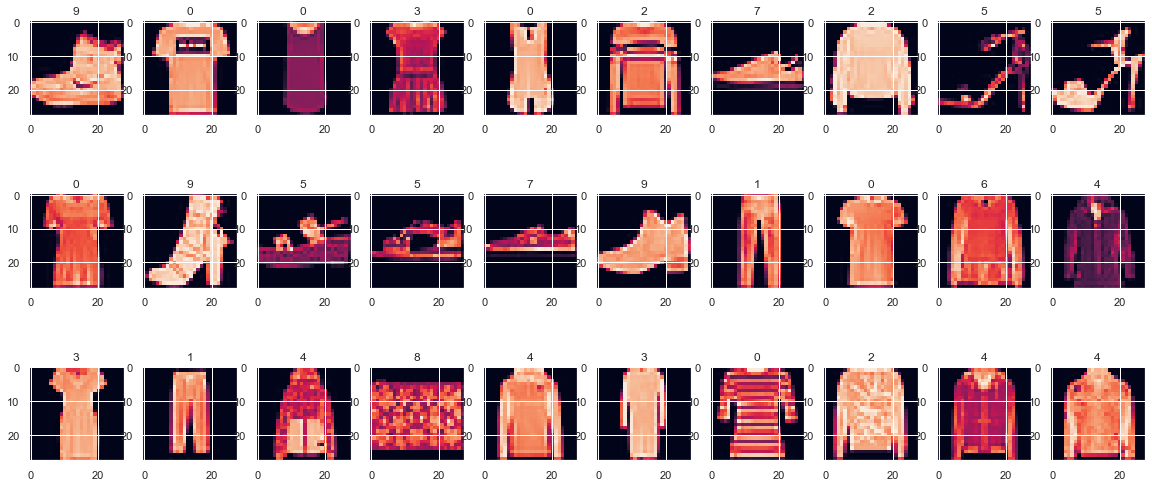

In [36]:
import matplotlib.pyplot as plt
p, axes = plt.subplots(3, 10, figsize=(20,9))

for i, x in enumerate( range(X_train[:30].shape[0])):  #range(30)):
    r = i // 10
    c = i % 10
    axes[r][c].imshow(X_train[x])   #, cmap=pyplot.get_cmap('gray'))
    axes[r][c].set_title(y_train[x])
# plt.show()

In [37]:
label = ['T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat',  'Sandal','Shirt','Sneaker','Bag','Ankle boot']

# X 데이터 가공

* <font color=red><b>CNN 모델 : shape(장수, H, W, 컬러) </b></font>

In [38]:
X_train_img = X_train.reshape(-1, 28, 28, 1)    #1:흑백  3:RGB(컬러)
X_test_img  = X_test.reshape(-1, 28, 28, 1)     #1:흑백  3:RGB(컬러)

In [39]:
X_train_img.shape, X_test_img.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

## 픽셀값 정규화
* 0 ~ 255 : 스케일링(MinMaxScaler)

In [40]:
X_train_scaler = X_train_img / 255.0
X_test_scaler  = X_test_img  / 255.0

# y label 평준화
*  (integers in range 0-9)

In [41]:
y_train_oh = to_categorical( y=y_train, num_classes=10, dtype='int32')
y_test_oh  = to_categorical( y=y_test,  num_classes=10, dtype='int32')

# CNN 모델 구축

In [42]:
INPUT_SHAPE__  = (28, 28, 1)                    #------------------- 주의주의주의
NUM_CLASS__    = 10                             #------------------- 총10개분류
ACTIVATION__   = "softmax"                      #------------------- sigmoid
LOSS__         = 'categorical_crossentropy'     #------------------- binary_crossentropy , sparse_crossentropy

#----------------------------------------------------------
model = Sequential([
    Conv2D(16, kernel_size=(3,3), input_shape=INPUT_SHAPE__ , activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(3,3),  activation='relu'),        
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    # ------------------------------- FC(Affine) -----------
    Dense(units=128, activation='relu'),
    Dense(units=NUM_CLASS__, activation=ACTIVATION__)  #다중분류 예측(0~9)

])
model.compile(loss=LOSS__,  optimizer='adam', metrics=['accuracy'])

In [43]:
# model.summary()

# 학습 & 평가

* <font color=red><b> X는 스케일된 데이터, y는 원핫인코딩 데이터
* callback 기능 : https://keras.io/api/callbacks/
    

<font color=red><B>Usage of callbacks via the built-in fit() loop
* Write TensorBoard logs after every batch of training to monitor your metrics<br>
<font color=red>* Periodically save your model to disk  ---------------------------------------------- 모델저장<br>
<font color=red>* Do early stopping   ---------------------------------------------------------------- 오버피팅 시 조기종료
* Get a view on internal states and statistics of a model during training

In [44]:
EPOCHS__      = 100
BATCH_SIZE__  = 128
PATIENCE__    = 5

In [45]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

In [47]:
MY_CALLBACKS__ = [
    EarlyStopping(patience=PATIENCE__),          #------------PATIENCE__ : 조기종료
    ModelCheckpoint(filepath='./model/mymodel_{epoch:02d}_{val_loss:.4f}.h5',
                    monitor='val_loss',          #------------어떤 점수를 기준으로 모니터링할까
                    save_best_only=True,         #------------이전보다 좋아질때만 저장
                    save_weights_only=False      #------------모델+가중치 같이 저장
                   )  # 이전 epoch 점수보다 현재 점수가 좋으면 모델 저장 : mymodel_03_2417.h5
] 

In [48]:
res = model.fit(X_train_scaler, 
                y_train_oh, 
                epochs=EPOCHS__, 
                batch_size=BATCH_SIZE__,        #128바이트씩 읽어라
                validation_split=0.1,           #학습:54만 ,  내부검증:6만
                callbacks=MY_CALLBACKS__        #----------- 옵션
               )

Epoch 1/100
422/422 [==============================] - 8s 18ms/step - loss: 0.6350 - accuracy: 0.7734 - val_loss: 0.4559 - val_accuracy: 0.8303
Epoch 2/100
422/422 [==============================] - 7s 17ms/step - loss: 0.4076 - accuracy: 0.8542 - val_loss: 0.4005 - val_accuracy: 0.8472
Epoch 3/100
422/422 [==============================] - 7s 17ms/step - loss: 0.3585 - accuracy: 0.8708 - val_loss: 0.3607 - val_accuracy: 0.8698
Epoch 4/100
422/422 [==============================] - 8s 18ms/step - loss: 0.3340 - accuracy: 0.8789 - val_loss: 0.3352 - val_accuracy: 0.8767
Epoch 5/100
422/422 [==============================] - 8s 18ms/step - loss: 0.3153 - accuracy: 0.8849 - val_loss: 0.3299 - val_accuracy: 0.8808
Epoch 6/100
422/422 [==============================] - 8s 19ms/step - loss: 0.3021 - accuracy: 0.8884 - val_loss: 0.3156 - val_accuracy: 0.8862
Epoch 7/100
422/422 [==============================] - 7s 18ms/step - loss: 0.2841 - accuracy: 0.8969 - val_loss: 0.3053 - val_accuracy:

In [49]:
loss_categorical_crossentropy , metrics_accuracy = model.evaluate(X_test_scaler, y_test_oh)

313/313 [==============================] - 1s 4ms/step - loss: 0.2787 - accuracy: 0.9061


# 학습 평가 시각화

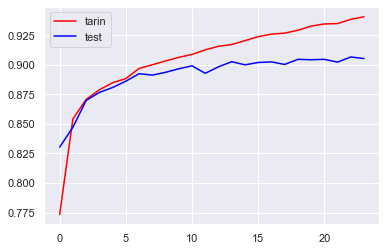

In [50]:
plt.plot(np.arange(len(res.history['accuracy'])), res.history['accuracy'], c='red', label='tarin')
plt.plot(np.arange(len(res.history['accuracy'])), res.history['val_accuracy'], c='blue', label='test')
plt.legend()
plt.show()

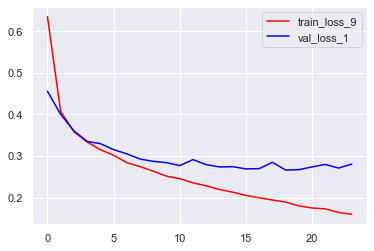

In [51]:
plt.plot(np.arange(len(res.history['val_loss'])), res.history['loss'], c='red', label='train_loss_9')
plt.plot(np.arange(len(res.history['val_loss'])), res.history['val_loss'], c='blue', label='val_loss_1')
plt.legend()
plt.show()

# 이미지 증강
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
* https://keras.io/ko/preprocessing/image/

In [53]:
# generator = ImageDataGenerator(featurewise_center=False, samplewise_center=False, 
#                                featurewise_std_normalization=False, 
#                                samplewise_std_normalization=False, 
#                                zca_whitening=False, zca_epsilon=1e-06, 
#                                rotation_range=0, width_shift_range=0.0, 
#                                height_shift_range=0.0, brightness_range=None, 
#                                shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, 
#                                fill_mode='nearest', cval=0.0, 
#                                horizontal_flip=False, vertical_flip=False, 
#                                rescale=None, 
#                                preprocessing_function=None, 
#                                data_format=None, 
#                                validation_split=0.0, dtype=None)

In [52]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

## 픽셀을 arr[28/28] 값으로 가지고 있는 경우

In [60]:
label[9]

'Ankle boot'

In [74]:
X_train_scaler.shape , y_train_oh.shape 

((60000, 28, 28, 1), (60000, 10))

In [73]:
X_train_scaler[0].shape, np.argmax(y_train_oh[0]), label[np.argmax(y_train_oh[0])]

((28, 28, 1), 9, 'Ankle boot')

## 이미지 보기

### matplot

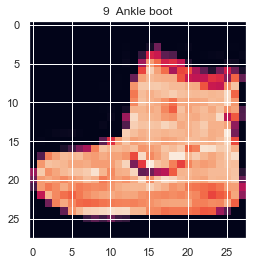

In [64]:
import matplotlib.pyplot as plt
plt.imshow(X_train_scaler[0])  #(28, 28, 1)
plt.title(f"{np.argmax(y_train_oh[0])}  {label[np.argmax(y_train_oh[0])]}")
plt.show()

### keras api

In [69]:
# from PIL import Image
# # from keras.utils.img_to_array
# from keras.preprocessing.image import array_to_img, img_to_array, load_image
# img   = array_to_img(X_train_scaler[0])
# array = img_to_array(img)
# load_image(img)
# print(array)

## ImageDataGenerator 만들기 

In [70]:
#================================= train만 증강 ===========================================
train_datagen = ImageDataGenerator( rescale=1./255,             #----------0 ~ 255 : 스케일링(MinMaxScaler)
                                    featurewise_center=True,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True)

#================================= test 증강XXXXXXXXXXXXXXXXXXXXXx =========================
test_datagen = ImageDataGenerator( rescale=1./255 )             #----------0 ~ 255 : 스케일링(MinMaxScaler)

In [ ]:
model.fit_generator(  train_datagen.flow(X_train_scaler, y_train_oh, batch_size=32),
                      steps_per_epoch=len(X_train_scaler) / 32, 
                      epochs=10)

Epoch 1/10
1875/1875 [==============================] - 33s 18ms/step - loss: 1.9031 - accuracy: 0.3100
Epoch 2/10
1875/1875 [==============================] - 30s 16ms/step - loss: 1.3175 - accuracy: 0.5099
Epoch 3/10
1875/1875 [==============================] - 33s 18ms/step - loss: 1.1171 - accuracy: 0.5828
Epoch 4/10
1875/1875 [==============================] - 34s 18ms/step - loss: 1.0108 - accuracy: 0.6187
Epoch 5/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.9464 - accuracy: 0.6421
Epoch 6/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.8969 - accuracy: 0.6624
Epoch 7/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.8713 - accuracy: 0.6693
Epoch 8/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.8524 - accuracy: 0.6790
Epoch 9/10
1033/1875 [===============>..............] - ETA: 11s - loss: 0.8318 - accuracy: 0.6875

* 연습용 : 이미지 증강 만들기

In [71]:
# import time
# for e in range(10):
#     print('Epoch', e)
#     batch_cnt = 0    #-----------------batch_size=32
#     for X_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=32):
#         model.fit(X_batch, y_batch)
#         batch_cnt += 1
        
#         if batch_cnt >= len(X_train) / 32:    #예: train(320장) - batch_size(32) ====> 총 증강된 이미지(10장)
#             break                             #예: train(320장) - batch_size(16) ====> 총 증강된 이미지(20장)
#         time.sleep(500)    

Epoch 0


ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (60000, 28, 28))

## 폴더의 이미지를 증강시킬 경우

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
img_list = image_dataset_from_directory(dir)
